In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
os.environ['HOME'] = '/data25/wuqin'
import clip
import torch
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# 导入模型
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("CS-ViT-B/16", device=device)
model = model.eval()

In [3]:
pil_img = Image.open("examples/kitchen/images/00.png")
cv2_img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
image = preprocess(pil_img).unsqueeze(0).to(device)
print(f'raw image shape: {image.shape}')
print(f'preprocessed image shape: {cv2_img.shape}')

raw image shape: torch.Size([1, 3, 224, 224])
preprocessed image shape: (520, 779, 3)


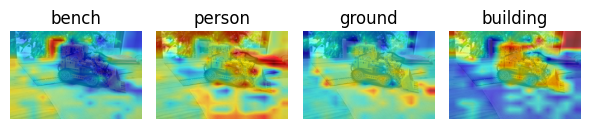

In [4]:
# 多目标查询
multi_texts = ['bench', 'person', 'ground', 'building']
with torch.no_grad():
    # CLIP architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, multi_texts, device)

    # Apply feature surgery
    similarity = clip.clip_feature_surgery(image_features, text_features)
    similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])

    # Draw similarity map
    fig, axes = plt.subplots(nrows=similarity_map.shape[0], ncols=similarity_map.shape[-1], figsize=(6, 4*similarity_map.shape[-1]))
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            axes[n].imshow(vis)
            axes[n].set_title(multi_texts[n])
            axes[n].axis('off')
    plt.tight_layout()
    plt.show()

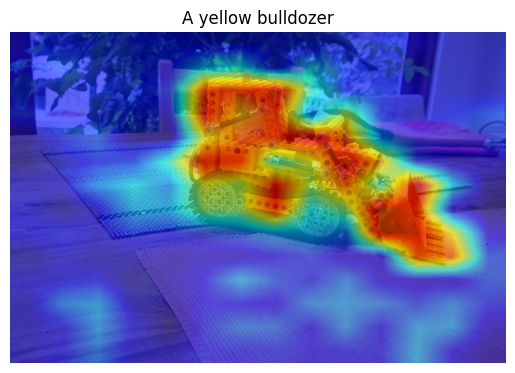

In [16]:
# 单目标查询
single_text = "A yellow bulldozer"
with torch.no_grad():
    # CLIP architecture surgery acts on the image encoder
    image_features = model.encode_image(image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    # Prompt ensemble for text features with normalization
    text_features = clip.encode_text_with_prompt_ensemble(model, [single_text], device)
    # Extract redundant features from an empty string
    redundant_features = clip.encode_text_with_prompt_ensemble(model, [""], device)

    # Apply feature surgery for single text
    similarity = clip.clip_feature_surgery(image_features, text_features, redundant_features)
    similarity_map = clip.get_similarity_map(similarity[:, 1:, :], cv2_img.shape[:2])

    # Draw similarity map
    for b in range(similarity_map.shape[0]):
        for n in range(similarity_map.shape[-1]):
            vis = (similarity_map[b, :, :, n].cpu().numpy() * 255).astype('uint8')
            vis = cv2.applyColorMap(vis, cv2.COLORMAP_JET)
            vis = cv2_img * 0.4 + vis * 0.6
            vis = cv2.cvtColor(vis.astype('uint8'), cv2.COLOR_BGR2RGB)
            plt.imshow(vis)
            plt.title(single_text)
            plt.axis('off')
            plt.show()